In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import scipy.stats
import numpy as np

# Generate some data:

In [2]:
from batchglm.api.models.nb_glm import Simulator

sim = Simulator(num_observations=2000, num_features=100)
sim.generate_sample_description(num_batches=4, num_confounders=0)
# sample parameters from positive truncated N(1, 0.1)
mu=1; phi=0.1
sim.generate_params(rand_fn_loc=lambda size: mu + scipy.stats.truncnorm.rvs(-mu / phi, np.infty, scale=phi, size=size))
sim.generate_data()

# count data
X = sim.X
# sample description
sample_description = sim.sample_description

The sample description should be a pandas DataFrame with `num_observations` rows.
Each column should represent a property of the dataset.

The module `batchglm.api.data` contains some helper functions which can be useful to create this sample description:

- `sample_description_from_anndata()`
- `sample_description_from_xarray()`

In [3]:
sample_description

,batch
observations,
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0


# Run differential expression test:

The pairwise test allows to perform comparisons between each group of samples to the remaining samples.

It needs a parameter `grouping` which assigns a group to each sample.
This `grouping` can either be a vector of length `num_observations` or a string specifying a column in the sample description.
Since we simulated `grouping` with `num_batches=4` different groups, the pairwise test will perform 4 different tests.

The parameter `test` specifies which kind of statistical test will be performed for each pair of groups.
Possible arguments are all `two_sample` tests (e.g. 'wald', 't-test', 'wilcoxon', ...).

In [4]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

import diffxpy as de

test = de.test_vsrest(
    data=X,
    grouping="batch",
    test="wald",
    noise_model="nb",
    sample_description=sample_description
)


Estimating model...
Using closed-form MLE initialization for mean
Using closed-form MME initialization for dispersion
training strategy: [{'learning_rate': 0.01, 'convergence_criteria': 't_test', 'stop_at_loss_change': 0.25, 'loss_window_size': 10, 'use_batching': False, 'optim_algo': 'GD'}]
Beginning with training sequence #1
Training sequence #1 complete
Estimating model ready
Estimating model...
Using closed-form MLE initialization for mean
Using closed-form MME initialization for dispersion
training strategy: [{'learning_rate': 0.01, 'convergence_criteria': 't_test', 'stop_at_loss_change': 0.25, 'loss_window_size': 10, 'use_batching': False, 'optim_algo': 'GD'}]
Beginning with training sequence #1
Training sequence #1 complete
Estimating model ready
Estimating model...
Using closed-form MLE initialization for mean
Using closed-form MME initialization for dispersion
training strategy: [{'learning_rate': 0.01, 'convergence_criteria': 't_test', 'stop_at_loss_change': 0.25, 'loss_windo

# Obtaining the results

The p-/q-values can be obtained by calling `test.pval` / `test.qval`:

In [5]:
np.set_printoptions(precision=3)
print("shape of p-values: %s" % str(test.pval.shape))

shape of p-values: (1, 4, 100)


p-values of first gene:

In [6]:
test.pval[:,:,0]

array([[0.017, 0.001, 0.005, 0.001]])

test.summary() returns a pandas DataFrame with a quick overview of the test results:

In [7]:
test.summary()

,gene,pval,qval,log2fc
0,0,5.075486e-04,1.227056e-03,0.107314
1,1,8.480332e-09,4.845904e-08,0.126318
2,2,6.727952e-14,6.900463e-13,0.219648
3,3,1.486460e-10,1.007769e-09,0.159523
4,4,0.000000e+00,0.000000e+00,0.179249
5,5,3.190430e-07,1.343339e-06,0.144761
6,6,2.641980e-03,5.391796e-03,0.173902
7,7,6.903369e-06,2.282105e-05,0.239847
8,8,0.000000e+00,0.000000e+00,0.321880
9,9,1.001808e-02,1.829786e-02,0.056188


- `gene`: gene name / identifier
- `pval`: minimal p-value of the tests
- `qval`: minimal multiple testing - corrected p-value of the tests
- `log2fc`: maximal $log_2$ fold change of the tests

`test.plot_volcano()` creates a volcano plot of p-values vs. fold-change:

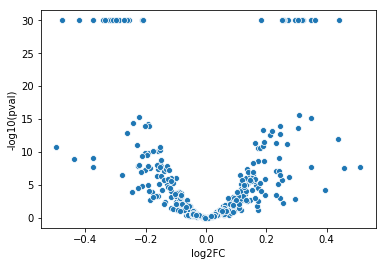

In [8]:
test.plot_volcano()
plt.show()

`test.plot_diagnostics()` is a shortcut to directly show all diagnostics plots.